## Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2
import classificationModelFunctions # all functions are defined in this module
import misclassificationVisualisationFunctions as mvf #module for handling misclassifications
import learning_from_misclassifications as lfm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas import set_option
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Loading the data

Loading csv file using pandas.

In [2]:
data_path = "../../../../../Downloads/defaults.csv"
df = classificationModelFunctions.loadDataAndPrintHead(data_path)

   id  limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   pay_amt4  pay_amt5  pay_amt6  defaulted  
0         0         0         0          

## Basic EDA
We see that column names are different from what we'd like them to be. So we rename column names to the first row and delete the first row.

In [3]:
df.columns # Column names before

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'defaulted'],
      dtype='object')

In [4]:
print(df.shape)
df['defaulted'] # Column names after


(30000, 25)


0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: defaulted, Length: 30000, dtype: int64

### Here we check if there are any null values in any of the columns

In [5]:
# basic eda

classificationModelFunctions.checkNullValues(df)

id           0
limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_0        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
defaulted    0
dtype: int64


### We drop the column 'ID' from the main dataframe and calculate a set of features by dropping the label.

In [6]:
# drop column "ID" and make features
y, features = classificationModelFunctions.makeFeaturesAndLabel(df)
features.shape

(30000, 23)

In [7]:
features.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


## Feature engineering

The data has been already encoded and cleaned. However, some categorical data have repeated categories. For instance, the variable ‘education’ has three categories with similar information:
4: others, 5: unknown, and 6: unknown

Similarly, the column 'marriage' should have three categories: 1 = married, 2 = single, 3 = others but it contains a category '0' which will be joined to the category '3'.


In [8]:
# before grouping
print(df['education'].unique())
print(df['marriage'].unique())

[2 1 3 5 4 6 0]
[1 2 3 0]


In [9]:
# after grouping
classificationModelFunctions.groupUnknownCategories(df)
print(df['education'].unique())
print(df['education'].unique())

[2 1 3 4]
[2 1 3 4]


### Printing a description of the data

In [10]:
set_option('display.width', 100)
set_option('precision', 2)

print("Stats for columns")
print(df.describe())

Stats for columns
        limit_bal       sex  education  marriage       age     pay_0     pay_2     pay_3  \
count    30000.00  30000.00   30000.00  30000.00  30000.00  30000.00  30000.00  30000.00   
mean    167484.32      1.60       1.84      1.56     35.49     -0.02     -0.13     -0.17   
std     129747.66      0.49       0.74      0.52      9.22      1.12      1.20      1.20   
min      10000.00      1.00       1.00      1.00     21.00     -2.00     -2.00     -2.00   
25%      50000.00      1.00       1.00      1.00     28.00     -1.00     -1.00     -1.00   
50%     140000.00      2.00       2.00      2.00     34.00      0.00      0.00      0.00   
75%     240000.00      2.00       2.00      2.00     41.00      0.00      0.00      0.00   
max    1000000.00      2.00       4.00      3.00     79.00      8.00      8.00      8.00   

          pay_4     pay_5  ...  bill_amt4  bill_amt5  bill_amt6   pay_amt1  pay_amt2   pay_amt3  \
count  30000.00  30000.00  ...   30000.00   30000.00  

## Visualization of the data
We plot some graphs to see the data distribution

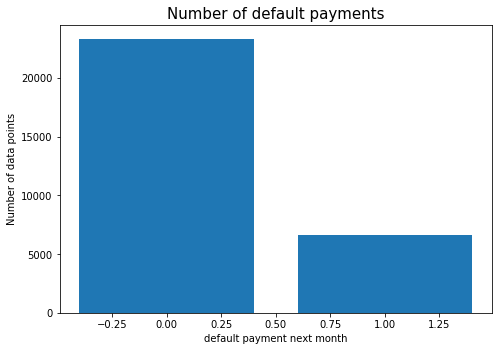

In [11]:
# graph to see the number of default payments

classificationModelFunctions.plotGrapthForDefaults(y)

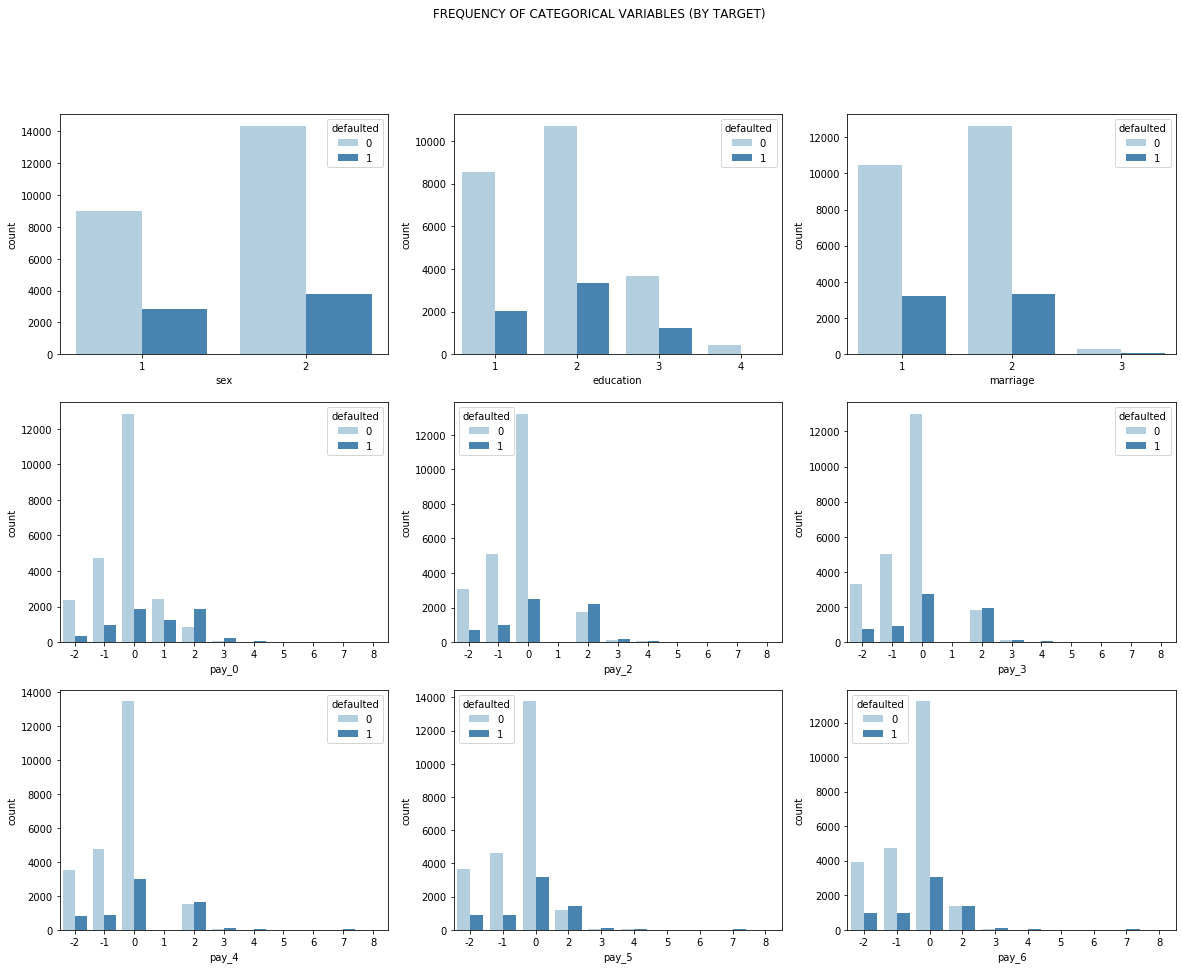

In [12]:
# graphs to visualize more attributes

classificationModelFunctions.plotGrapthForAttributes(df)

In [13]:
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4',
       'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'defaulted'],
      dtype='object')

There are 30,000 credit card clients.

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

## Splitting the data

Use sklearn to split the data

In [14]:
X_train, X_test, y_train, y_test = classificationModelFunctions.splitData(df, features, y)

## Standardization of data 

All features are centered around zero and have variance one.

In [15]:
X_train['age'] = X_train['age'].astype(float)
mean = np.mean(X_train['age'])
std = np.std(X_train['age'])
print(mean, std)
print(X_train.head())

35.500238095238096 9.226798440798328
       limit_bal  sex  education  marriage   age  pay_0  pay_2  pay_3  pay_4  pay_5  ...  \
28465     240000    2          1         1  40.0     -2     -2     -2     -2     -2  ...   
27622      50000    2          1         2  23.0     -1     -1     -1     -1     -1  ...   
28376      50000    2          2         1  36.0      2      2      2      2      0  ...   
10917     200000    2          3         1  54.0      6      5      4      3      2  ...   
27234     240000    1          1         1  35.0     -1     -1     -1      0     -1  ...   

       bill_amt3  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
28465          0          0          0          0         0         0         0         0   
27622       2299       4800       9810        660      2548      2321      4800      9810   
28376      49125      47956      43578      35126         0      4700         0      2004   
10917     104686     102549     101400

/home/soniya51/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
classificationModelFunctions.standardizeData(X_test, X_train)

       limit_bal  sex  education  marriage   age  pay_0  pay_2  pay_3  pay_4  pay_5  ...  \
28465       0.56    2          1         1  0.49     -2     -2     -2     -2     -2  ...   
27622      -0.91    2          1         2 -1.35     -1     -1     -1     -1     -1  ...   
28376      -0.91    2          2         1  0.05      2      2      2      2      0  ...   
10917       0.25    2          3         1  2.01      6      5      4      3      2  ...   
27234       0.56    1          1         1 -0.05     -1     -1     -1      0     -1  ...   

       bill_amt3  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
28465      -0.68      -0.67      -0.67      -0.66     -0.33     -0.24     -0.29     -0.30   
27622      -0.64      -0.60      -0.50      -0.65     -0.18     -0.15     -0.02      0.31   
28376       0.03       0.08       0.06      -0.06     -0.33     -0.05     -0.29     -0.18   
10917       0.84       0.93       1.01      -0.66     -0.33     -0.24     -

/home/soniya51/Repos/PRESC/dev/Soniyanayak51/issue63/classificationModelFunctions.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col_to_norm] = standardize(X_test[col_to_norm], X_train[col_to_norm])
/home/soniya51/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/soniya51/Repos/PRESC/dev/Soniyanayak51/issue63/classificationModelFunctions.py:179: SettingWithCopyWarning: 
A value is trying to be se

## Model 1: Logistic Regression

First, I try a simple logistic regression model for the classification. This is a baseline model and gives an idea if the data is linearly separable.

In [17]:
lr_preds, logisticRegressionScore, lr_model = classificationModelFunctions.logisticRegressionModel(X_train, y_train, X_test, y_test)

### Accuracy of Logistic Regression model
Check the accuracy for test data

In [18]:
print(logisticRegressionScore)

0.8087777777777778


This accuracy shows that neural networks will overfit the data and simple svm will be a good choice after logistic regression.

## Model 2: SVM model

I use the sklearn svm model(sklearn.svm.SVC). The accuracy is shown with the confusion matrix.

Kernel methods give better results for non-linear binary classifications and we can see that the scatterplot is somewhat not linearly seperable.

In [19]:
SVMScore, prediction_SVM, SVM_Model = classificationModelFunctions.svmModel(X_train, y_train, X_test, y_test)

[LibSVM]

### Accuracy of SVM Model
Check the accuracy for test data

In [20]:
print (SVMScore)

Accuracy - : 0.820


## Confusion matrix
tn - true positives, tp - true negatives, fn - false negatives, fp - false positives

Sensitivity/Recall = TP/(TP + FN). When it’s actually yes, how often does it predict yes? 

Specificity = TN/(TN + FP) .When it’s actually no, how often does it predict no?

Precision = TP/predicted yes. When it predicts yes, how often is it correct?

Analysis of above measures of accuracy for both models.

### 1. Confusion matrix for svm model.

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_SVM).ravel()
confusion_matrix(y_test, prediction_SVM)

array([[6717,  323],
       [1300,  660]])

In [22]:
print(tp/(tp+fn)) # Sensitivity/Recall
print(tn/(tn+fp)) # Specificity
print(tp/(tp+fp)) # Precision

0.336734693877551
0.9541193181818182
0.671414038657172






### 2. Confusion matrix for logistic regression model.

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_preds).ravel()
confusion_matrix(y_test, lr_preds)

array([[6824,  216],
       [1505,  455]])

In [24]:
print(tp/(tp+fn)) # Sensitivity/Recall
print(tn/(tn+fp)) # Specificity
print(tp/(tp+fp)) # Precision

0.23214285714285715
0.9693181818181819
0.6780923994038748


## Results

### Logistic Regression
Test Accuracy - 0.809

### SVM
Test Accuracy - 0.82

## Visualization of Misclassifications
The function misclassificationGraphs() in module mvf plots Seaborn counplots to visualise the binary classifications.

We first see the data for logistic regression and then SVM classification.

### 1. Logistic Regression

In [25]:
df_miss_lr = mvf.misclassificationGraphHelper(y_test, lr_preds) # obtaining misclassified data for plotting

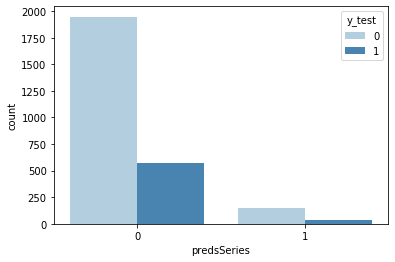

In [26]:
mvf.misclassificationGraphs(df_miss_lr)

### 2. SVM Classification

In [27]:
df_miss_svm = mvf.misclassificationGraphHelper(y_test, prediction_SVM) # obtaining misclassified data for plotting

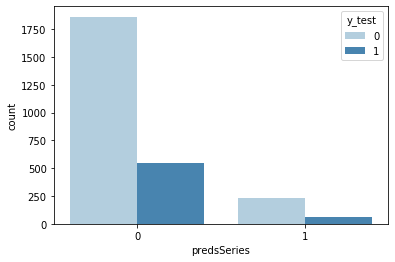

In [28]:
mvf.misclassificationGraphs(df_miss_svm)


## Learning from misclassifications

I have used the sklearn SVC.decision_function to compute the relative distance of each data point from the decision boundary. Since a non-linear kernel has been used in the SVC model, decision_function can be used as a relative distance.(presence in the hyperplane)

For linear kernel, the decision boundary is y = w * x + b, the distance from point x to the decision boundary is y/||w||. which can be calculated by:

y = svc.decision_function(x)

w_norm = np.linalg.norm(svc.coef_)

dist = y / w_norm

In [29]:
relative_distance_to_decision_boundary = lfm.distanceFromDecisionBoundary(SVM_Model, X_test)

In [30]:
relative_distance_to_decision_boundary

array([-1.0016395 , -1.00316741, -1.00122871, ..., -1.00222235,
       -1.0046152 , -1.00506372])

## SVM Model

### The following functions plots the correctly classified(red) and misclassified(black) points w.r.t the decision boundary(y-axis)

1623
7377


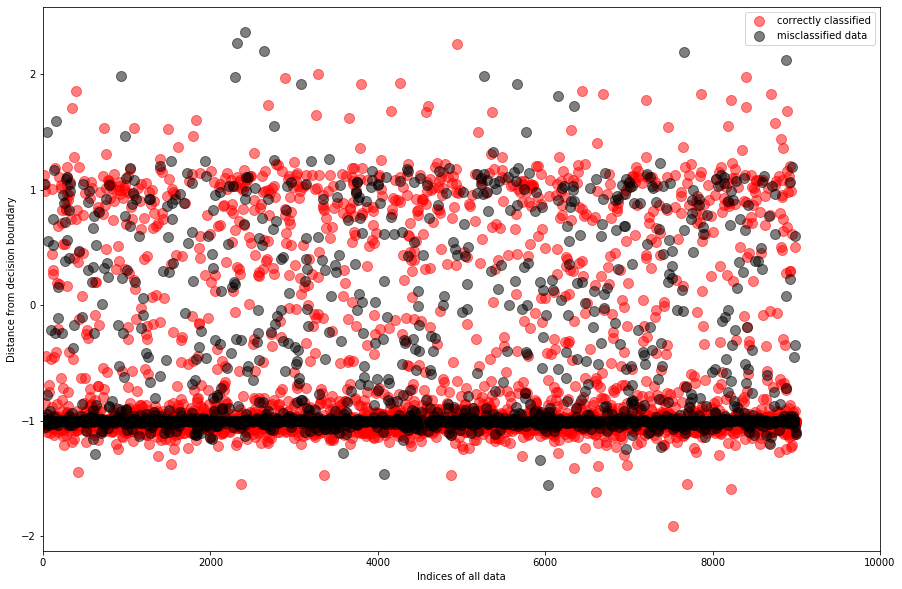

In [31]:
# Using distance from decision boundary
lfm.plotDistancesFromDecisionBoundary(relative_distance_to_decision_boundary, prediction_SVM, y_test, "Distance from decision boundary")

1623
7377


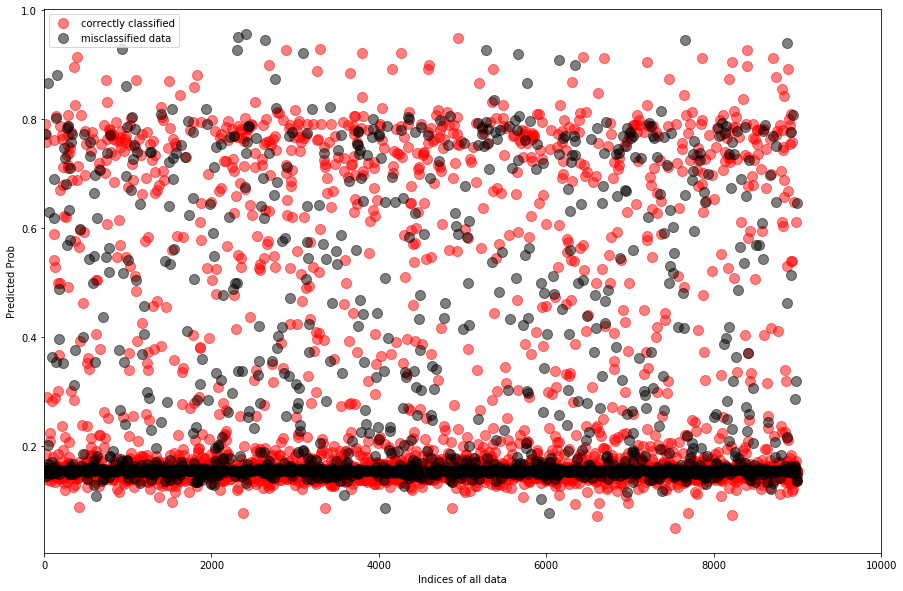

In [32]:
# Using predicted probabilities
lfm.plotDistancesFromDecisionBoundary(SVM_Model.predict_proba(X_test)[:,1], prediction_SVM, y_test, "Predicted Prob")

We can see that the classifier is biased towards the 0 class as the original data is hugely biased towards class 0.

## Logistic regression model

In [33]:
relative_distance_to_decision_boundary = lfm.distanceFromDecisionBoundary(lr_model, X_test)

1721
7279


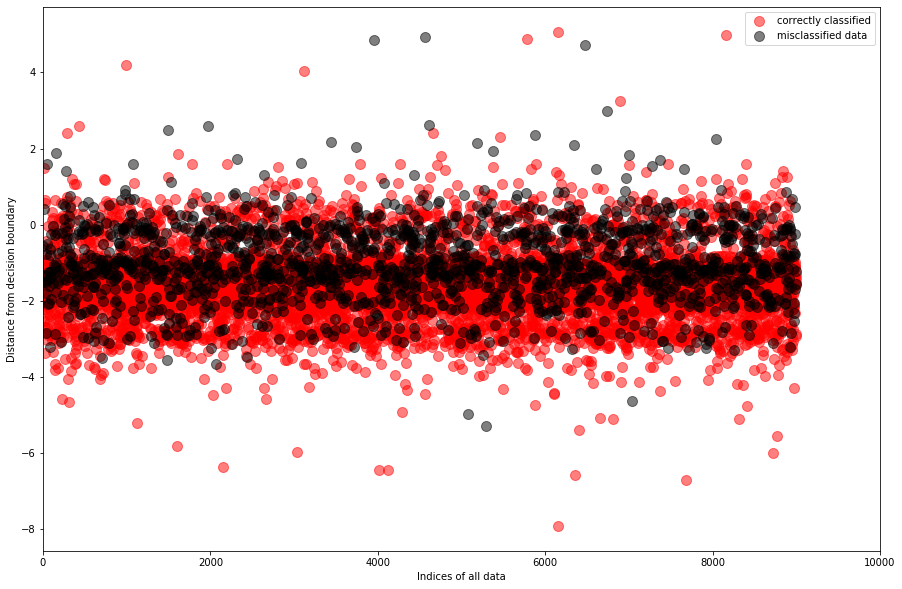

In [34]:
# Using distance from decision boundary
lfm.plotDistancesFromDecisionBoundary(relative_distance_to_decision_boundary, lr_preds, y_test, "Distance from decision boundary")

1721
7279


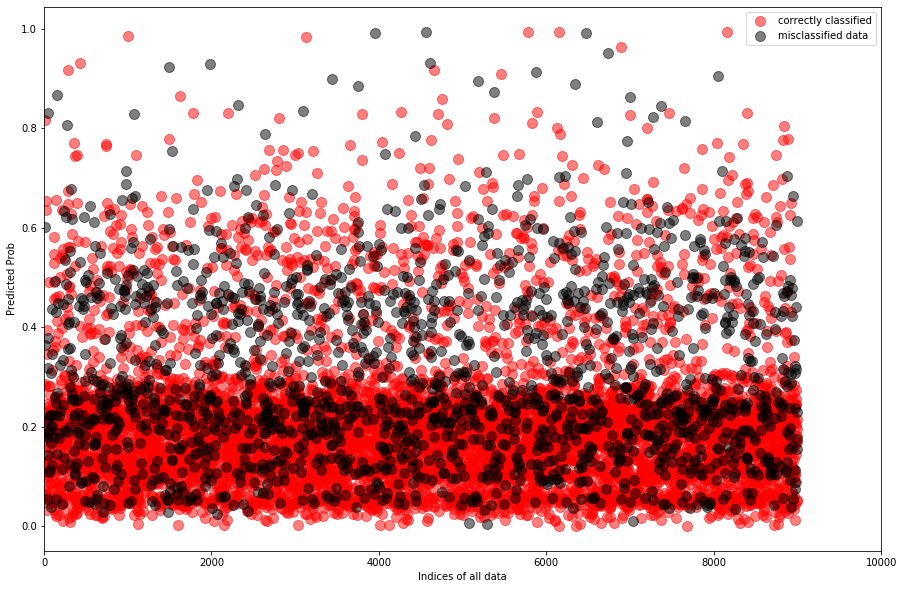

In [35]:
# Using predicted probabilities
lfm.plotDistancesFromDecisionBoundary(lr_model.predict_proba(X_test)[:,1], lr_preds, y_test, "Predicted Prob")